# Continuum Normalization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

### Read in Observed Spectra

In [172]:
DataDir = 'U112/'
MaskDir = 'm15msk/'
PlotDir = 'spec1d_plots/'

Obj = 'spec1d.m15msk.004.0000029'
Obj2 = 'spec1d.m15msk.005.0000030'
Obj3 = 'spec1d.m15msk.007.0000034'
Obj4 = 'spec1d.m15msk.010.0010510'

ObjHDUL = fits.open(DataDir + MaskDir + Obj4 + '.fits')

BoxB = ObjHDUL['Bxspf-B'].data
LambdaB = np.array(BoxB['LAMBDA'][0])
SpecB = np.array(BoxB['SPEC'][0])
IvarB = np.array(BoxB['IVAR'][0])

BoxR = ObjHDUL['Bxspf-R'].data
LambdaR = np.array(BoxR['LAMBDA'][0])
SpecR = np.array(BoxR['SPEC'][0])
IvarR = np.array(BoxR['IVAR'][0])

Lambda = np.concatenate((LambdaB,LambdaR))
Spec = np.concatenate((SpecB,SpecR))
Ivar = np.concatenate((IvarB,IvarR))

### Read in Synthetic Spectra

In [78]:
xmin = 6000
xmax = 9500

temp = np.load("payne/metal_poor_solar_spectra.npz")
feh = temp["feh"]
wavelength = temp["wavelength"]
normalized_spectra = temp["normalized_spectra"][1]
normalized_spectra = normalized_spectra[(wavelength > xmin) & (wavelength < xmax)]
full_spectra = temp["full_spectra"][1]
full_spectra = full_spectra[(wavelength > xmin) & (wavelength < xmax)]
wavelength = wavelength[(wavelength > xmin) & (wavelength < xmax)]

### Unnormalized Spectra

Synthetic (Dwarf, [Fe/H] = -1):

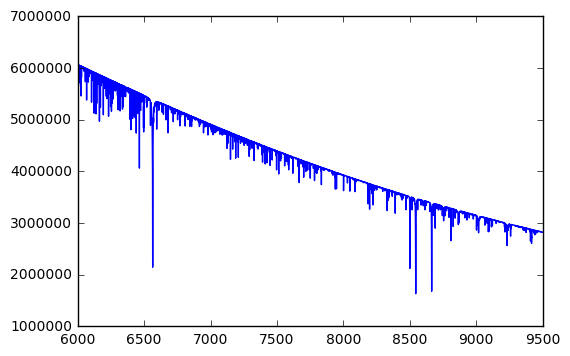

In [79]:
plt.plot(wavelength,full_spectra)
plt.xlim(xmin,xmax)
plt.show()

Observed:

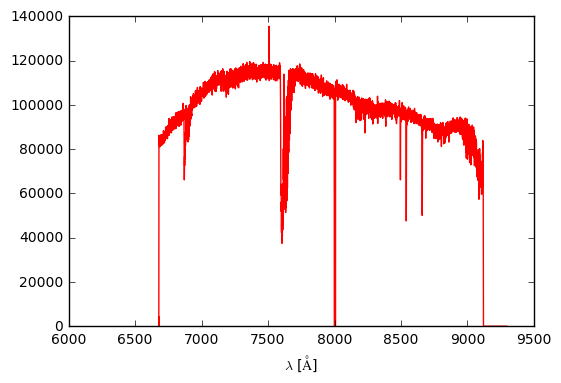

In [152]:
plt.plot(Lambda,Spec,c='r')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.xlim(xmin,xmax)
plt.show()

### Continuum Normalization a la Kirby et al. 2008

Kirby+ 2008 determines the continuum locally by taking an average of neighboring wavelengths, weighting by inverse variance and wavelength proximity. I've used the normalized synthetic spectrum to determine continuum regions free from absorption lines. I define a continuum region to be a region where the normalized spectra is greater than 0.99 for at least 0.5 angstrom.

Ideally the synthetic spectra would have a resolution matching the observations so that n and m below would be the same.

For Synthetic Spectrum:

In [81]:
# Continuum Regions (Kirby+ 2008 Eq. 4)
temp = np.zeros(len(wavelength))
temp[normalized_spectra > 0.99] = 1
n = np.zeros(len(wavelength))
for i, item in enumerate(wavelength):
    n[i] = np.floor(np.average(temp[(wavelength > item - 0.25) &
                                 (wavelength < item + 0.25)]))
cont_reg = interpolate.interp1d(wavelength, n)

# Weights (Kirby+ 2008 Eq. 3)
LambdaDiff_synth = wavelength[:,np.newaxis] - wavelength
w = 1 * np.exp(-np.power(LambdaDiff_synth/10,2) / 2 ) 

# Continuum Spectrum (Kirby+ 2008 Eq. 2)
num = np.sum(full_spectra * n * w,axis=1)
den = np.sum(n * w,axis=1)
c_synth = num/den 

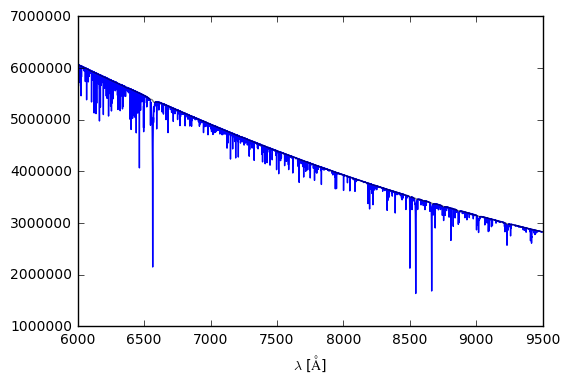

In [82]:
plt.plot(wavelength,full_spectra,c='b')
plt.plot(wavelength,c_synth,alpha=0.5,c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.show()

For Observed Spectrum:

In [173]:
# Continuum Regions (Kirby+ 2008 Eq. 4)
m = np.floor(cont_reg(Lambda))

# Weights (Kirby+ 2008 Eq. 3)
LambdaDiff = Lambda[:,np.newaxis] - Lambda
w = Ivar * np.exp(-np.power(LambdaDiff/10,2) / 2 ) 

# Continuum Spectrum (Kirby+ 2008 Eq. 2)
num = np.sum(Spec * m * w,axis=1)
den = np.sum(m * w,axis=1)
c = num/den

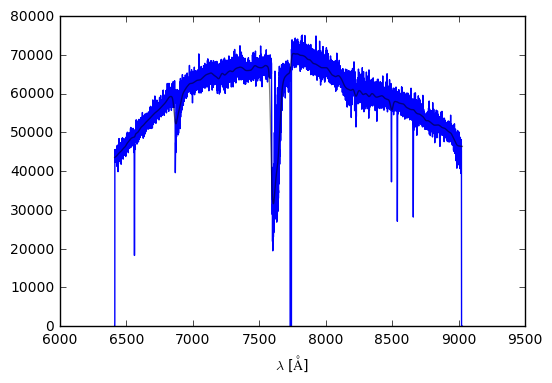

In [174]:
plt.plot(Lambda,Spec,c='b')
plt.plot(Lambda,c,alpha=0.5,c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.show()

### Continuum Normalization w/ Polynomial Fit

Fitting with a polynomial of degree two. I fit both the entire spectrum weighting by inverse variance as well as only the continuum regions found above.

For Synthetic Spectrum:

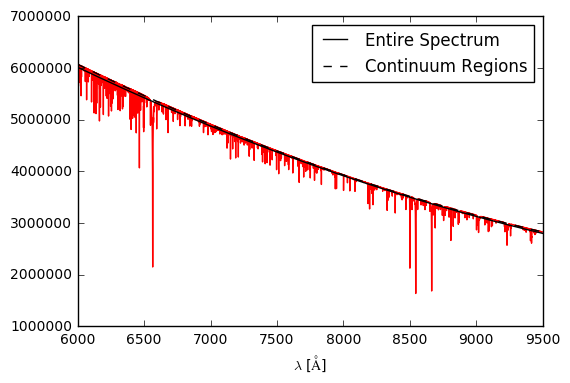

In [86]:
c2 = np.polyfit(wavelength,full_spectra,deg=2)
c2_synth = np.poly1d(c2)
c3 = np.polyfit(wavelength[n==1],full_spectra[n==1],deg=2)
c3_synth = np.poly1d(c3)

plt.plot(wavelength,full_spectra,c='r')
plt.plot(wavelength,c2_synth(wavelength),c='k',label='Entire Spectrum')
plt.plot(wavelength,c3_synth(wavelength),c='k',ls='--',label='Continuum Regions')

plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.legend()
plt.show()

For Observed Spectrum:

/Users/Nathan/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/Nathan/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


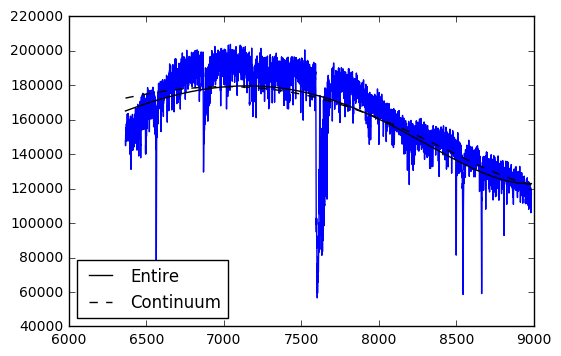

In [142]:
c2 = np.polyfit(Lambda[Spec>0],
                Spec[Spec>0],deg=12,
                w=np.sqrt(Ivar[Spec>0]))
c2 = np.poly1d(c2)
c3 = np.polyfit(Lambda[m==1],
                Spec[m==1],deg=12,
                w=np.sqrt(Ivar[m==1]))
c3 = np.poly1d(c3)

plt.plot(Lambda[Spec>0],
         Spec[Spec>0],c='b')
plt.plot(Lambda[Spec>0],
         c2(Lambda[Spec>0]),c='k',label='Entire')
plt.plot(Lambda[Spec>0],
         c3(Lambda[Spec>0]),c='k',ls='--',label='Continuum')
plt.legend(loc=3)

plt.show()

### Comparison of normalization methods

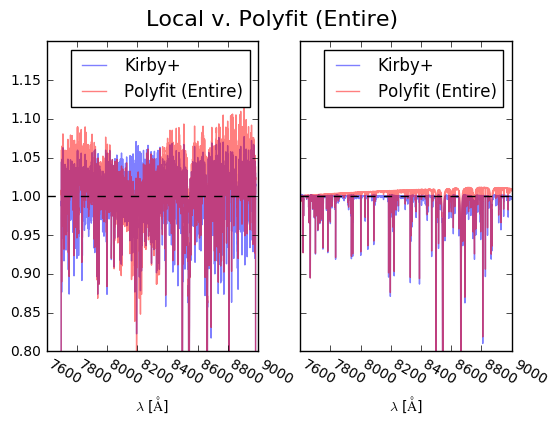

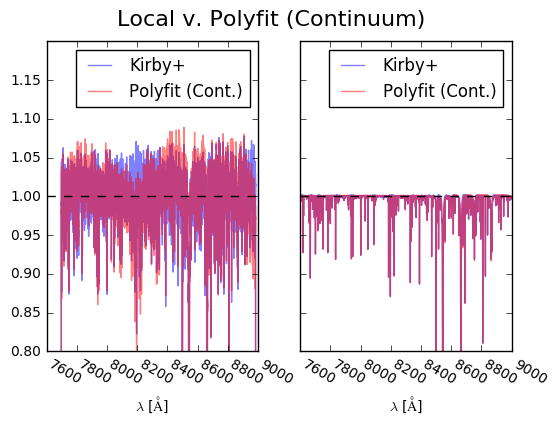

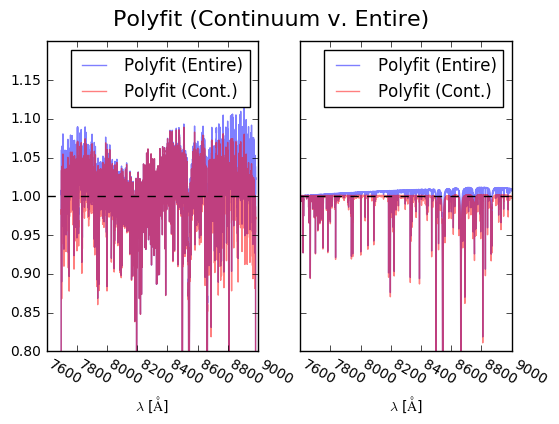

In [71]:
ax1 = plt.subplot(121)
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c,alpha=0.5,label='Kirby+')
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c2(BoxR['LAMBDA'][0]),
         c='r',alpha=0.5,label='Polyfit (Entire)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.ylim(0.8,1.2)
plt.legend(loc=1)
plt.setp(ax1.get_xticklabels(),rotation=330,horizontalalignment='left')

ax2 = plt.subplot(122)
plt.plot(wavelength,full_spectra/c_synth,alpha=0.5,label='Kirby+')
plt.plot(wavelength,full_spectra/c2_synth(wavelength),
         c='r',alpha=0.5,label='Polyfit (Entire)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.legend(loc=1)
plt.ylim(0.8,1.2)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(),rotation=330,horizontalalignment='left')

plt.suptitle('Local v. Polyfit (Entire)', fontsize=16)

plt.show()





ax1 = plt.subplot(121)
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c,alpha=0.5,label='Kirby+')
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c3(BoxR['LAMBDA'][0]),
         c='r',alpha=0.5,label='Polyfit (Cont.)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.ylim(0.8,1.2)
plt.legend(loc=1)
plt.setp(ax1.get_xticklabels(),rotation=330,horizontalalignment='left')

ax2 = plt.subplot(122)
plt.plot(wavelength,full_spectra/c_synth,alpha=0.5,label='Kirby+')
plt.plot(wavelength,full_spectra/c3_synth(wavelength),
         c='r',alpha=0.5,label='Polyfit (Cont.)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.legend(loc=1)
plt.ylim(0.8,1.2)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(),rotation=330,horizontalalignment='left')

plt.suptitle('Local v. Polyfit (Continuum)', fontsize=16)

plt.show()





ax1 = plt.subplot(121)
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c2(BoxR['LAMBDA'][0]),alpha=0.5,label='Polyfit (Entire)')
plt.plot(BoxR['LAMBDA'][0],BoxR['SPEC'][0]/c3(BoxR['LAMBDA'][0]),
         c='r',alpha=0.5,label='Polyfit (Cont.)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.ylim(0.8,1.2)
plt.legend(loc=1)
plt.setp(ax1.get_xticklabels(),rotation=330,horizontalalignment='left')

ax2 = plt.subplot(122)
plt.plot(wavelength,full_spectra/c2_synth(wavelength),alpha=0.5,label='Polyfit (Entire)')
plt.plot(wavelength,full_spectra/c3_synth(wavelength),
         c='r',alpha=0.5,label='Polyfit (Cont.)')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.legend(loc=1)
plt.ylim(0.8,1.2)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(),rotation=330,horizontalalignment='left')

plt.suptitle('Polyfit (Continuum v. Entire)', fontsize=16)

plt.show()

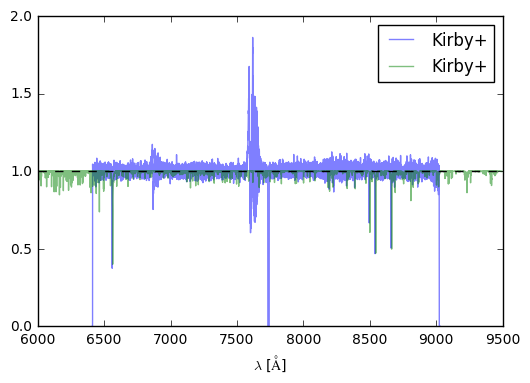

In [175]:
plt.plot(Lambda,Spec/c,alpha=0.5,label='Kirby+')
plt.plot(wavelength,full_spectra/c_synth,alpha=0.5,label='Kirby+')
plt.plot((xmin,xmax),(1,1),ls='--',c='k')
plt.xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
plt.legend(loc=1)
plt.show()

In [176]:
np.savez(Obj4+'.npz',Lambda=Lambda,Norm_Spec=Spec/c)

In [148]:
npzfile = np.load(Obj+'.npz')

array([ 6364.08544922,  6364.40576172,  6364.7265625 , ...,  8985.37695312,
        8985.68066406,  8985.984375  ], dtype=float32)